In [107]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [108]:
from sklearn.manifold import TSNE
from sklearn import preprocessing

##### Read the data

In [109]:
# read the data
df = pd.read_csv('../experiments/model-prediction.csv')

In [110]:
df_auc = pd.read_csv('../experiments/data-processed.csv')

In [111]:
df.head()

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model2442,model2443,model2444,model2445,model2446,model2447,model2448,model2449,model2450,model2451
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
# get the values from the auc data processed df
auc_values = df_auc['acc'].values
# delete the last value as the model deleted the last occurence
#auc_values = np.delete(auc_values, -1)
# create a new columm with the acc results from the data processed
df['auc'] = auc_values 

##### Get the data from the batches

In [113]:
f=open("../src/auc.txt", "r")

In [118]:
# array with all the lines from the file
auc0 = []
auc1 = []
auc2 = []
auc3 = []
auc4 = []


for x in f:
    list = x.split(",")
    for i in range(len(list)):
        cleanString = re.sub('[^a-zA-Z0-9 \n\.]', '', list[i])
        if i == 0:
            auc0.append(float(cleanString))
        elif i == 1:
            auc1.append(float(cleanString))
        elif i == 2:
            auc2.append(float(cleanString))
        elif i == 3:
            auc3.append(float(cleanString))
        else:
            auc4.append(float(cleanString))

In [117]:
#auc0.pop()
#auc1.pop()
#auc2.pop()
#auc3.pop()
#auc4.pop()
print(len(auc1))
print(df.shape)

0
(5204, 2454)


In [116]:
df['auc0'] = auc0
df['auc1'] = auc1
df['auc2'] = auc2
df['auc3'] = auc3
df['auc4'] = auc4

ValueError: Length of values does not match length of index

In [86]:
df.auc0

0       0.562432
1       0.516849
2       0.610601
3       0.643621
4       0.611206
          ...   
5199    0.733132
5200    0.675915
5201    0.730818
5202    0.696396
5203    0.726189
Name: auc0, Length: 5204, dtype: float64

##### Round the values with 3 decimals

In [53]:
df.auc = df.auc.round(decimals=3)
df.auc0 = df.auc0.round(decimals=3)
df.auc1 = df.auc1.round(decimals=3)
df.auc2 = df.auc2.round(decimals=3)
df.auc3 = df.auc3.round(decimals=3)
df.auc4 = df.auc4.round(decimals=3)

TypeError: can't multiply sequence by non-int of type 'float'

##### Select the top 10 models

In [11]:
df = df.sort_values('auc',ascending=False)
df = df.head(637)

##### Calculate the MAC from the 5 batches

In [12]:
#Calculate MAD
df_mad = df[['auc0', 'auc1', 'auc2', 'auc3', 'auc4']].copy()
df['mad_'] = df_mad.mad(axis=1)

##### Calculate the variation

In [13]:
#df['variation'] = df['mad'] / df['auc']
#variation = df['variation']
df['mad_'] = 1 / df['mad_']

##### Normalize the auc values

In [14]:
accs=df['auc'].tolist()

def change_list(accs):
    count = 0
    acc_return = []
    for i in accs:
        if count < 128:
            acc_return.append(0.809)
        elif count < 256:
            acc_return.append(0.803)
        elif count < 384:
            acc_return.append(0.797)
        elif count < 512:
            acc_return.append(0.791)
        else:
            acc_return.append(0.785)
        count = count + 1
    return acc_return

acc_return = change_list(accs)
df["auc"] = acc_return

##### Cleaning the dataset

In [15]:
results = df.auc.values
mad = df.mad_.values
df = df.drop('auc', axis=1)
#df = df.drop('var', axis=1)
df = df.drop('mad_', axis=1)
df = df.drop('auc0', axis=1)
df = df.drop('auc1', axis=1)
df = df.drop('auc2', axis=1)
df = df.drop('auc3', axis=1)
df = df.drop('auc4', axis=1)
#df = df.drop('variation', axis=1)
df['auc'] = results 

In [16]:
df.auc.value_counts()

0.797    128
0.791    128
0.803    128
0.809    128
0.785    125
Name: auc, dtype: int64

##### Separate the data

In [17]:
# split data into X and y
array = df.values
X = array[:,0:171]
Y = array[:,171]

### T-SNE

In [18]:
tsne = TSNE(n_components=2, 
            random_state=0,
            perplexity=30,
            learning_rate=200,
            n_iter=1000,
            init='pca')

In [19]:
tsne_obj = tsne.fit_transform(X)

In [20]:
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                         'acc':Y})

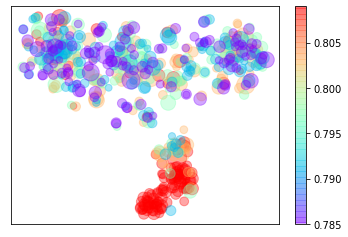

In [21]:
# plot the result
vis_x = tsne_obj[:, 0]
vis_y = tsne_obj[:, 1]
#classes = ['0.809', '0.803', '0.797', '0.791', '0.785']
scatter = plt.scatter(vis_x, vis_y, c=Y, s=mad,
                      cmap='rainbow', 
                      alpha=0.35)
plt.colorbar(scatter)
plt.xticks([])
plt.yticks([])
plt.grid()
plt.savefig('../reports/result.png', bbox_inches='tight', dpi=800)
plt.show()

#### That's all forks!!!